# Practical 1b: Hyperparameter Tuning

© Machine Learning Summer School - Telkom University

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/MLSS2020_Telkom/blob/master/practical%201/MLSS2020TU%20-%20Practical%201b.ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
    
</td><td>
<a href="https://github.com/adf-telkomuniv/MLSS2020_Telkom/blob/master/practical%201/MLSS2020TU%20-%20Practical%201b.ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>

---
## Hyperparameter

Hyperparameters are variables whose value is set by the model designer before the learning process begins. These variables remain constant over the training process and directly impact the performance of your ML program.

hyperparameters might address model design questions such as:
* model (architectural) hyperparameters:
  * degree of polynomial features in linear model
  * number of layers and neurons in Neural Network
  * type of layers to use in Deep Learning
  * etc.

* training (algorithm) hyperparameters:
  * K value for Nearest Neighbors
  * learning rate for Gradient Descent
  * regularization
  * dropout value
  * etc.

This is in contrast to the weights in Artificial Neural Network, which are the values of parameters that are learned through the algorithm. 

---
## Optimization Approaches

There are several approaches to address this optimization problem. The most common of it are:
* Traditional Grid Search
 * commonly used to optimize width, depth, and types of layer in ANN
 * find the K value for KNN or Kernel type for SVMs
* Random Search
 * can be used to optimize the initial learning rate
* Bayesian opmitization
 * also used to optimize the initial learning rate
* Evolutionary optimization


<table>
  <tr><td  align="center">
    <img src="https://images.ctfassets.net/be04ylp8y0qc/1m1AB8NPTcKkuEaqg2Zgyg/e56d45a2c85b99820ead8159a280323f/hp_tuning_flow_1f745fd5e0ae8830804bab6a66e2c917_1000.png" width="80%" 
         alt="Hyperparameter tuning process">
  </td></tr>
  <tr><td align="center">
    <b>Figure:</b>Hyperparameter tuning process.<br/>
  </td></tr>
</table>


Grid Search optimization usually incorporated with K-Fold Cross-Validation scheme, while the rest only uses Hold-out validation. Especially in learning with huge dataset, prefer one validation fold to cross-validation. In most cases a single validation set of respectable size substantially simplifies the code base, without the need for cross-validation with multiple folds

For Neural Network and Deep Learning, Hyperparameter Tuning is usually only done with a little epoch in order to find a combination of hyperparameter that has the highest potential for the "actual" training process.

---
# [Part 0] Preparation

## Import Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

%matplotlib inline


## Load Fashion MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step


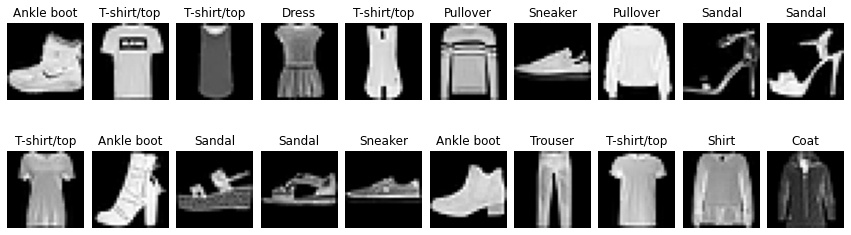

In [3]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train[i+j*10], cmap='gray')
        ax[j,i].set_title(class_names[y_train[i+j*10]])
        ax[j,i].axis('off')
plt.show()

In [4]:
X_val = X_train[-10000:,:]
y_val = y_train[-10000:]

X_train = X_train[:-10000, :]
y_train = y_train[:-10000]


In [5]:
X_train = X_train.astype('float32') / 255.
X_val   = X_val.astype('float32') / 255.
X_test  = X_test.astype('float32') / 255.

---
#[Part 1] Keras Tuner

<img src = "https://i.ibb.co/4RyZpZ2/keras-tuner.png" height="200" align = "center">

Keras tuner is a hyperparameter optimization library (Hyperparameter tuner) built specifically for `tf.keras` with TensorFlow 2.0. It was introduced at the Google I/O 2019 event. 

This library is intended for AI practitioners, hypertuner algorithm creators, and model designers. It can be as simple as possible to build a model with a clean and easy API. Keras Tuner comes with Bayesian Optimization, Hyperband, and Random Search algorithms built-in, and is also designed to be easy for researchers to extend in order to experiment with new search algorithms.

read more: [Documentation](https://keras-team.github.io/keras-tuner/), [github repository](https://github.com/keras-team/keras-tuner)


---
## 1 - Installation

First, install Keras Tuner 

In [6]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 61kB 4.8MB/s 


In [7]:
import kerastuner as kt

---
## 2 - Define Hyperparameter Range

In this example, we'll only use a Two-Layer Neural Network, and we're going to tune the layer width (number of hidden neuron), type of activation function, and the learning rate. Both hyperparameter range and the model need to be defined inside a method to feed into the tuner object. So in this part, we'll see the explanations first, then later the actual implementations.

### Layer Width

For this hyperparameter, we'll use grid choice to iterate from 128 to 256 with 64 increment. For that we use `Int()` method as follow

```python 
    ch_unit = hp.Int('units', min_value=128, max_value=256, step=64) 
```

### Activation Function
For the activation function, let's try `relu`, `tanh`, and `sigmoid` function. For that we use `Choice()` method as follow
```python
    ch_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='relu')
```

### Learning Rate
The learning rate represents how fast the learning algorithm progresses.The learning rate may, in fact, be the most important hyperparameter to configure for your model. Unfortunately, we cannot analytically calculate the optimal learning rate for a given model on a given dataset. Instead, a good (or good enough) learning rate must be discovered via trial and error. 

Arguably, it is actually not the best thing to tune learning rate using grid search. As mentioned by Bergstra and Bengio in [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf), “randomly chosen trials are more efficient for hyper-parameter optimization than trials on a grid”. 

<table>
  <tr><td  align="center">
    <img src="https://cs231n.github.io/assets/nn3/gridsearchbad.jpeg" width="50%" 
         alt="Grid vs Random Layout.">
  </td></tr>
  <tr><td align="center">
    <b>Figure:</b> Grid vs Random Layout illustration from [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).
  </td></tr>
</table>

Usually, the learning rate is chosen on a log scale. Intuitively, this is because learning rate have multiplicative effects on the training dynamics. This prior knowledge can be incorporated in the search through the setting of the sampling method:

```python
    ch_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
```

## 3 - Define Model

Now to define a function to build the model. We still use the usual Keras API, but feed in the choice for each hyperparameter. The function takes an argument hp from which we can use to sample the hyperparameters.


> <font color='red'>**EXERCISE**: </font> Define your classification model. 


In [8]:
def build_model(hp):
  
    ch_unit = hp.Int('units', min_value=128, max_value=256, step=64)
    ch_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='relu')
    ch_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)

    # define model
    model = Sequential([
                Flatten(input_shape=(28,28)), 
                Dense(units=ch_unit, activation=ch_activation),
                Dense(10, activation='softmax')
            ])

    # compile model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(ch_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

---
# [Part 2] Initialize The Tuner

The Keras Tuner has four tuners available - **RandomSearch**, **Hyperband**,  **Bayesian Optimization** and **Sklearn**. In this exercise, we'll focus on random search and Hyperband. We won't go into theory, but for Hyperband, its main idea is to optimize Random Search in terms of search time.

In here we can specify the model-building function, the name of the `objective` (metrics) to optimize, the total number of trials (`max_trials`) to test, and the number of models that should be built and fit for each trial (`executions_per_trial`). 

Similar to K-Fold Cross Validation, the purpose of having multiple executions per trial is to reduce results variance and therefore be able to more accurately assess the performance of a model.



In [9]:
from kerastuner.tuners import RandomSearch, Hyperband

---
## 1 - Random Search Tuner
The most intuitive way to perform hyperparameter tuning is to randomly sample hyperparameter combinations and test them out. 

### Initialize Random Tuner
Here we will do the tuning experiment 4 times, with the best model selection metrics based on validation accuracy. The `max_trials` variable represents the number of hyperparameter combinations that will be tested by the tuner, while the `execution_per_trial` variable is the number of models that should be built and fit for each trial for robustness purposes.

In [10]:
tuner_random = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=2,
    directory='random_search',
    project_name='mnist_random'
    )


Once the model and the tuner are set up, we can view the search space summary

In [11]:
tuner_random.search_space_summary()

### Run Random Tuning Process

Now we can start the Optimization for just 5 epochs. The arguments for the search method are the same as those used for `tf.keras.model.fit` 

Depend on how big your search space is, it might take a while.

In [12]:
tuner_random.search(X_train, y_train,
             batch_size=256,
             epochs=5,
             validation_data=(X_val, y_val))

Epoch 1/5
196/196 [==============================] - 1s 4ms/step - loss: 2.0852 - accuracy: 0.3002 - val_loss: 1.6772 - val_accuracy: 0.5789
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 1.4458 - accuracy: 0.6282 - val_loss: 1.2530 - val_accuracy: 0.6605
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 1.1452 - accuracy: 0.6766 - val_loss: 1.0436 - val_accuracy: 0.6972
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.9875 - accuracy: 0.7056 - val_loss: 0.9238 - val_accuracy: 0.7207
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.8905 - accuracy: 0.7293 - val_loss: 0.8460 - val_accuracy: 0.7411
Epoch 1/5
196/196 [==============================] - 1s 3ms/step - loss: 2.0663 - accuracy: 0.2873 - val_loss: 1.6658 - val_accuracy: 0.5383
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 1.4324 - accuracy: 0.6115 - val_loss: 1.2460 - val_accuracy: 0.6524
Epoch 3/5
196

Epoch 1/5
196/196 [==============================] - 1s 3ms/step - loss: 1.0969 - accuracy: 0.6711 - val_loss: 0.6894 - val_accuracy: 0.7899
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 0.6147 - accuracy: 0.8055 - val_loss: 0.5649 - val_accuracy: 0.8141
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.5293 - accuracy: 0.8278 - val_loss: 0.5113 - val_accuracy: 0.8265
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.4866 - accuracy: 0.8383 - val_loss: 0.4798 - val_accuracy: 0.8360
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.4586 - accuracy: 0.8472 - val_loss: 0.4594 - val_accuracy: 0.8399
Epoch 1/5
196/196 [==============================] - 1s 3ms/step - loss: 1.0501 - accuracy: 0.6741 - val_loss: 0.6777 - val_accuracy: 0.7821
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 0.6090 - accuracy: 0.8061 - val_loss: 0.5614 - val_accuracy: 0.8140
Epoch 3/5
196

Epoch 1/5
196/196 [==============================] - 1s 4ms/step - loss: 0.5617 - accuracy: 0.8038 - val_loss: 0.4480 - val_accuracy: 0.8237
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3914 - accuracy: 0.8572 - val_loss: 0.4154 - val_accuracy: 0.8466
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3626 - accuracy: 0.8678 - val_loss: 0.3759 - val_accuracy: 0.8590
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3447 - accuracy: 0.8729 - val_loss: 0.3890 - val_accuracy: 0.8582
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3394 - accuracy: 0.8756 - val_loss: 0.3792 - val_accuracy: 0.8623
Epoch 1/5
196/196 [==============================] - 1s 4ms/step - loss: 0.5584 - accuracy: 0.8025 - val_loss: 0.4124 - val_accuracy: 0.8447
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 0.4031 - accuracy: 0.8521 - val_loss: 0.4044 - val_accuracy: 0.8482
Epoch 3/5
196

Epoch 1/5
196/196 [==============================] - 1s 3ms/step - loss: 1.6687 - accuracy: 0.4988 - val_loss: 1.2312 - val_accuracy: 0.6677
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 1.0466 - accuracy: 0.7009 - val_loss: 0.9071 - val_accuracy: 0.7290
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.8373 - accuracy: 0.7473 - val_loss: 0.7737 - val_accuracy: 0.7593
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.7351 - accuracy: 0.7740 - val_loss: 0.6976 - val_accuracy: 0.7794
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.6727 - accuracy: 0.7902 - val_loss: 0.6491 - val_accuracy: 0.7929
Epoch 1/5
196/196 [==============================] - 1s 3ms/step - loss: 1.6870 - accuracy: 0.5304 - val_loss: 1.2002 - val_accuracy: 0.6696
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 1.0218 - accuracy: 0.6925 - val_loss: 0.8875 - val_accuracy: 0.7273
Epoch 3/5
196

INFO:tensorflow:Oracle triggered exit


### View the Search Summary

Finally, the search results can be summarized and used

In [13]:
tuner_random.results_summary()

### Show The Best Hyperparameter

In [14]:
import tensorflow.keras.backend as K

# Retrieve the best model.
best_model_random = tuner_random.get_best_models(num_models=1)[0]
best_model_random.summary()

print('Best Initial Learning Rate =', K.eval(best_model_random.optimizer.lr))
print('Activation Function used   =', best_model_random.layers[1].get_config()['activation'],)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 192)               150720    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1930      
Total params: 152,650
Trainable params: 152,650
Non-trainable params: 0
_________________________________________________________________
Best Initial Learning Rate = 0.007863429
Activation Function used   = tanh


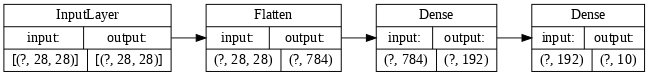

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(best_model_random, 
           to_file='best_random.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='LR',
           dpi=70
          )


---
## 2 - Hyperband Tuner
Hyperband is an optimized version of random search which uses early-stopping to speed up the hyperparameter tuning process. The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. 


The main idea is to fit a large number of models for a small number of epochs and to only continue training for the models achieving the highest accuracy on the validation set. The `max_epochs` variable is the max number of epochs that a model can be trained for.

### Initialize Hyperband Tuner
Here we will do the tuning experiment 4 times, with the best model selection metrics based on validation accuracy.

In [16]:
tuner_hyperband = Hyperband(
    build_model,
    max_epochs=5,
    objective='val_accuracy',
    executions_per_trial=2,
    directory='hyperband',
    project_name='mnist_hyperband'
)



Once the model and the tuner are set up, we can view the search space summary

In [17]:
tuner_hyperband.search_space_summary()

### Run Hyperband Tuning Process

Now we can start the Optimization for just 5 epochs. 

In [18]:
tuner_hyperband.search(X_train, y_train,
             batch_size=256,
             epochs=5,
             validation_data=(X_val, y_val))

Epoch 1/2
196/196 [==============================] - 1s 4ms/step - loss: 0.5948 - accuracy: 0.7935 - val_loss: 0.4545 - val_accuracy: 0.8415
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 0.4215 - accuracy: 0.8514 - val_loss: 0.4119 - val_accuracy: 0.8529
Epoch 1/2
196/196 [==============================] - 1s 3ms/step - loss: 0.5982 - accuracy: 0.7919 - val_loss: 0.4571 - val_accuracy: 0.8326
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 0.4220 - accuracy: 0.8514 - val_loss: 0.4052 - val_accuracy: 0.8560


Epoch 1/2
196/196 [==============================] - 1s 3ms/step - loss: 1.9119 - accuracy: 0.4241 - val_loss: 1.5790 - val_accuracy: 0.6067
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 1.3725 - accuracy: 0.6428 - val_loss: 1.1986 - val_accuracy: 0.6805
Epoch 1/2
196/196 [==============================] - 1s 4ms/step - loss: 1.9466 - accuracy: 0.3953 - val_loss: 1.6059 - val_accuracy: 0.6070
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 1.3897 - accuracy: 0.6394 - val_loss: 1.2124 - val_accuracy: 0.6672


Epoch 1/2
196/196 [==============================] - 1s 3ms/step - loss: 0.5554 - accuracy: 0.8045 - val_loss: 0.4403 - val_accuracy: 0.8426
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 0.3969 - accuracy: 0.8590 - val_loss: 0.3881 - val_accuracy: 0.8604
Epoch 1/2
196/196 [==============================] - 1s 3ms/step - loss: 0.5531 - accuracy: 0.8040 - val_loss: 0.4388 - val_accuracy: 0.8410
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 0.3979 - accuracy: 0.8585 - val_loss: 0.4005 - val_accuracy: 0.8499


Epoch 1/2
196/196 [==============================] - 1s 3ms/step - loss: 0.7881 - accuracy: 0.7416 - val_loss: 0.5543 - val_accuracy: 0.8124
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 0.4914 - accuracy: 0.8346 - val_loss: 0.4676 - val_accuracy: 0.8385
Epoch 1/2
196/196 [==============================] - 1s 3ms/step - loss: 0.7816 - accuracy: 0.7463 - val_loss: 0.5461 - val_accuracy: 0.8136
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 0.4920 - accuracy: 0.8349 - val_loss: 0.4714 - val_accuracy: 0.8341


Epoch 1/2
196/196 [==============================] - 1s 3ms/step - loss: 0.8980 - accuracy: 0.7127 - val_loss: 0.6070 - val_accuracy: 0.7998
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 0.5445 - accuracy: 0.8214 - val_loss: 0.5108 - val_accuracy: 0.8287
Epoch 1/2
196/196 [==============================] - 1s 3ms/step - loss: 0.9196 - accuracy: 0.7062 - val_loss: 0.6132 - val_accuracy: 0.8023
Epoch 2/2
196/196 [==============================] - 1s 3ms/step - loss: 0.5524 - accuracy: 0.8160 - val_loss: 0.5130 - val_accuracy: 0.8271


Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.5514 - accuracy: 0.8027 - val_loss: 0.4336 - val_accuracy: 0.8453
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3968 - accuracy: 0.8578 - val_loss: 0.3877 - val_accuracy: 0.8557
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3578 - accuracy: 0.8710 - val_loss: 0.3542 - val_accuracy: 0.8702
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.5652 - accuracy: 0.8021 - val_loss: 0.4381 - val_accuracy: 0.8416
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3977 - accuracy: 0.8577 - val_loss: 0.4057 - val_accuracy: 0.8535
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3618 - accuracy: 0.8704 - val_loss: 0.3646 - val_accuracy: 0.8691


Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.6018 - accuracy: 0.7943 - val_loss: 0.4566 - val_accuracy: 0.8367
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.4231 - accuracy: 0.8510 - val_loss: 0.4043 - val_accuracy: 0.8541
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3862 - accuracy: 0.8630 - val_loss: 0.3937 - val_accuracy: 0.8571
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.5855 - accuracy: 0.7959 - val_loss: 0.4493 - val_accuracy: 0.8401
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.4207 - accuracy: 0.8509 - val_loss: 0.4122 - val_accuracy: 0.8541
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3851 - accuracy: 0.8628 - val_loss: 0.3832 - val_accuracy: 0.8629


Epoch 1/5
196/196 [==============================] - 1s 4ms/step - loss: 1.6623 - accuracy: 0.5726 - val_loss: 1.2287 - val_accuracy: 0.7105
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 1.0610 - accuracy: 0.7370 - val_loss: 0.9306 - val_accuracy: 0.7485
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.8575 - accuracy: 0.7638 - val_loss: 0.7912 - val_accuracy: 0.7708
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.7504 - accuracy: 0.7809 - val_loss: 0.7113 - val_accuracy: 0.7844
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.6827 - accuracy: 0.7922 - val_loss: 0.6553 - val_accuracy: 0.7950
Epoch 1/5
196/196 [==============================] - 1s 3ms/step - loss: 1.6409 - accuracy: 0.5942 - val_loss: 1.2240 - val_accuracy: 0.7185
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 1.0573 - accuracy: 0.7324 - val_loss: 0.9298 - val_accuracy: 0.7477
Epoch 3/5
196

Epoch 1/5
196/196 [==============================] - 1s 3ms/step - loss: 0.5707 - accuracy: 0.8000 - val_loss: 0.4808 - val_accuracy: 0.8260
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.8582 - val_loss: 0.3805 - val_accuracy: 0.8673
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3658 - accuracy: 0.8695 - val_loss: 0.3944 - val_accuracy: 0.8595
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3388 - accuracy: 0.8777 - val_loss: 0.3767 - val_accuracy: 0.8622
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.3176 - accuracy: 0.8846 - val_loss: 0.3438 - val_accuracy: 0.8806
Epoch 1/5
196/196 [==============================] - 1s 4ms/step - loss: 0.5598 - accuracy: 0.8046 - val_loss: 0.4473 - val_accuracy: 0.8443
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 0.4040 - accuracy: 0.8569 - val_loss: 0.3892 - val_accuracy: 0.8606
Epoch 3/5
196

Epoch 1/5
196/196 [==============================] - 1s 4ms/step - loss: 1.3081 - accuracy: 0.6502 - val_loss: 0.8724 - val_accuracy: 0.7471
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 0.7622 - accuracy: 0.7708 - val_loss: 0.6844 - val_accuracy: 0.7813
Epoch 3/5
196/196 [==============================] - 1s 3ms/step - loss: 0.6378 - accuracy: 0.7952 - val_loss: 0.6014 - val_accuracy: 0.8002
Epoch 4/5
196/196 [==============================] - 1s 3ms/step - loss: 0.5740 - accuracy: 0.8135 - val_loss: 0.5552 - val_accuracy: 0.8131
Epoch 5/5
196/196 [==============================] - 1s 3ms/step - loss: 0.5332 - accuracy: 0.8216 - val_loss: 0.5238 - val_accuracy: 0.8203
Epoch 1/5
196/196 [==============================] - 1s 3ms/step - loss: 1.2891 - accuracy: 0.6611 - val_loss: 0.8573 - val_accuracy: 0.7570
Epoch 2/5
196/196 [==============================] - 1s 3ms/step - loss: 0.7537 - accuracy: 0.7745 - val_loss: 0.6780 - val_accuracy: 0.7827
Epoch 3/5
196

INFO:tensorflow:Oracle triggered exit


### View the Search Summary

Finally, the search results can be summarized and used

In [19]:
tuner_hyperband.results_summary()

### Show The Best Hyperparameter

In [20]:
# Retrieve the best model.
best_model_hyperband = tuner_hyperband.get_best_models(num_models=1)[0]
best_model_hyperband.summary()

print('Best Initial Learning Rate =', K.eval(best_model_hyperband.optimizer.lr))
print('Activation Function used   =', best_model_random.layers[1].get_config()['activation'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Best Initial Learning Rate = 0.0030505336
Activation Function used   = tanh


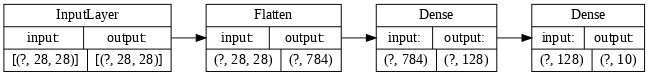

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(best_model_hyperband, 
           to_file='best_hyperband.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='LR',
           dpi=70
          )


---
## 3 - Evaluate Best Model

In [22]:
# loss, accuracy = best_model_random.evaluate(X_test, y_test)

loss, accuracy = best_model_hyperband.evaluate(X_test, y_test)

print('Validation Accuracy =',accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3686 - accuracy: 0.8724
Validation Accuracy = 0.8723999857902527


---
### View Result
Now to visualize some of the model's predictions:

In [23]:
# y_pred = best_model_random.predict(X_test, verbose=0)

y_pred = best_model_hyperband.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

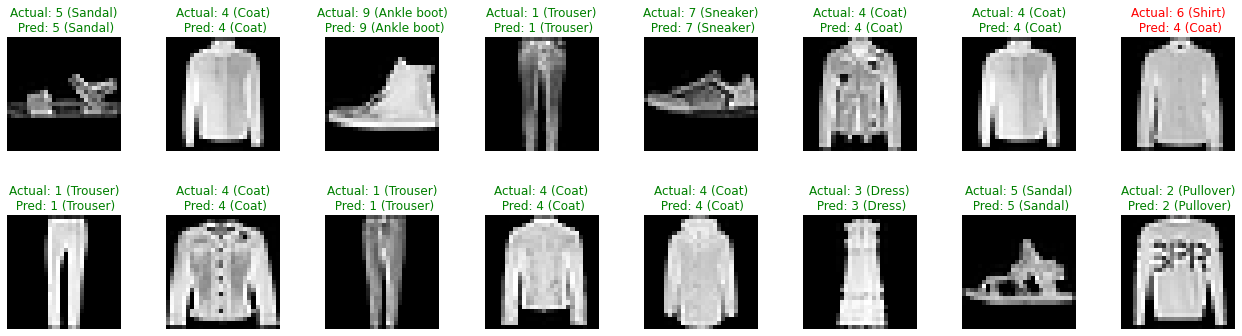

In [24]:
fig, ax = plt.subplots(2,8,figsize=(22,6))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

for j in range(0,2):
    for i in range(0, 8):

        img_index = np.random.randint(0, 10000)
        ax[j,i].imshow(X_test[img_index], cmap='gray')

        actual_label    = int(y_test[img_index])
        predicted_label = int(y_pred[img_index])

        color = 'red'
        if actual_label == predicted_label:
            color = 'green'

        ax[j,i].set_title("Actual: {} ({})\n Pred: {} ({})".format(
            actual_label, class_names[actual_label], predicted_label, class_names[predicted_label]
            ), color=color)
        ax[j,i].axis('off')
plt.show()

---

# Congratulation

<font size=5> You've Completed Practical 1b</font>

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>